In [1]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [3]:
MOVIELENS_DIR = 'dat'
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

In [4]:
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [5]:
USERS_CSV_FILE = 'users.csv'
MOVIES_CSV_FILE = 'movies.csv'
RATINGS_CSV_FILE = 'ratings.csv'

In [6]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Set max_user_id to the maximum user_id in the ratings
max_user_id = ratings['user_id'].drop_duplicates().max()
# Set max_movie_id to the maximum movie_id in the ratings
max_movie_id = ratings['movie_id'].drop_duplicates().max()

# Add user_emb_id column whose values == user_id - 1
ratings['user_emb_id'] = ratings['user_id'] - 1
# Add movie_emb_id column whose values == movie_id - 1
ratings['movie_emb_id'] = ratings['movie_id'] - 1

print(len(ratings), 'ratings loaded')

1000209 ratings loaded


In [7]:
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_id', 'movie_id', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])
print('Saved to', RATINGS_CSV_FILE)

Saved to ratings.csv


In [8]:
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_user_id, 'users loaded.')

6040 descriptions of 6040 users loaded.


In [9]:
users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])
print('Saved to', USERS_CSV_FILE)

Saved to users.csv


In [10]:
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
print(len(movies), 'descriptions of', max_movie_id	, 'movies loaded.')

3883 descriptions of 3952 movies loaded.


In [11]:
movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_id', 'title', 'genres'])
print('Saved to', MOVIES_CSV_FILE)

Saved to movies.csv


In [12]:
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

### Ratings Dataset

In [13]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  1000209  ratings of  3883  movies.


In [14]:
ratings.head()

user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [16]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


### Users Dataset

In [17]:
users.head()

user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   6040 non-null   int64 
 1   gender    6040 non-null   object
 2   zipcode   6040 non-null   object
 3   age_desc  6040 non-null   object
 4   occ_desc  6040 non-null   object
dtypes: int64(1), object(4)
memory usage: 236.1+ KB


### Movies Dataset

In [19]:
movies.head()

movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

In [20]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


# Data Exploration

### Titles

In [21]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

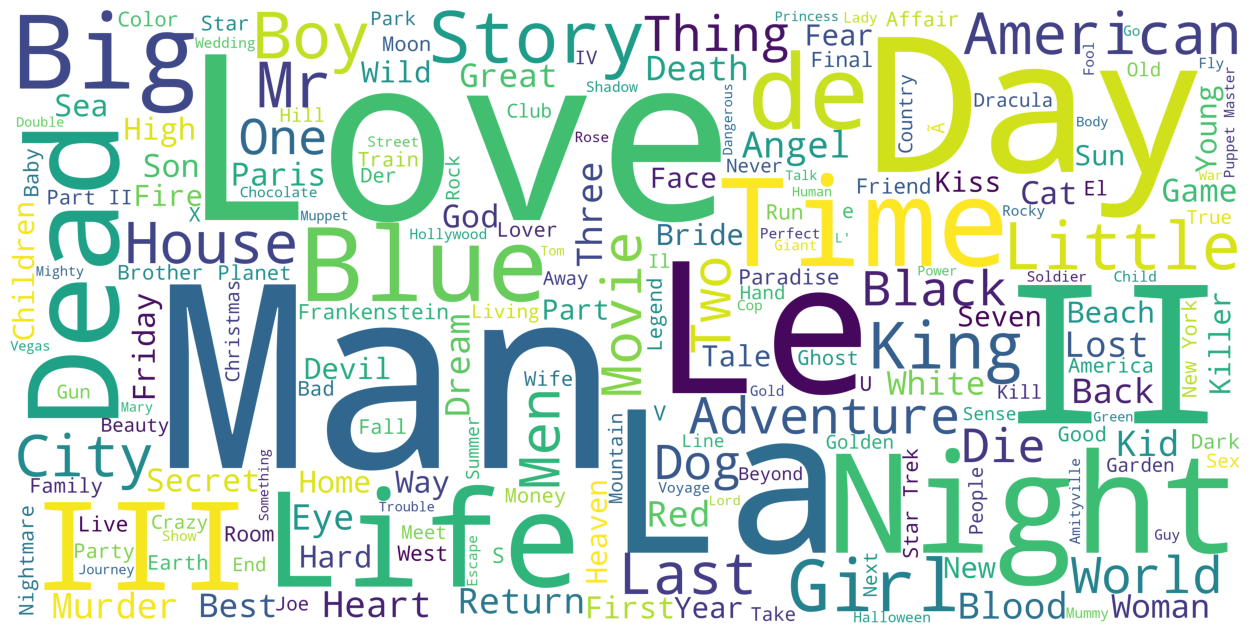

In [22]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='White', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [23]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(df, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in df[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

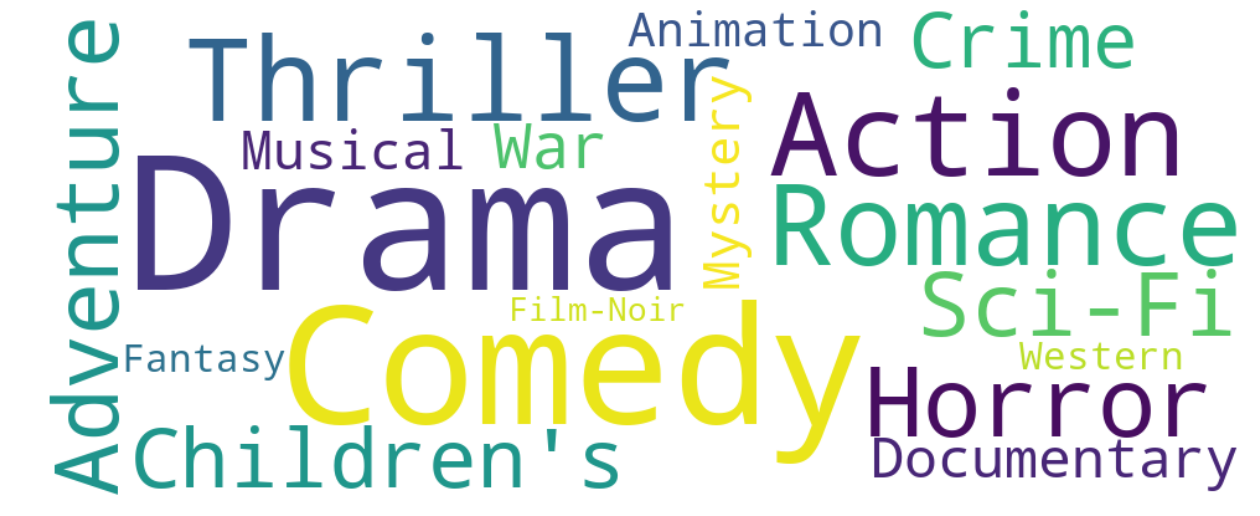

In [24]:
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
df = pd.merge(pd.merge(movies, ratings),users)

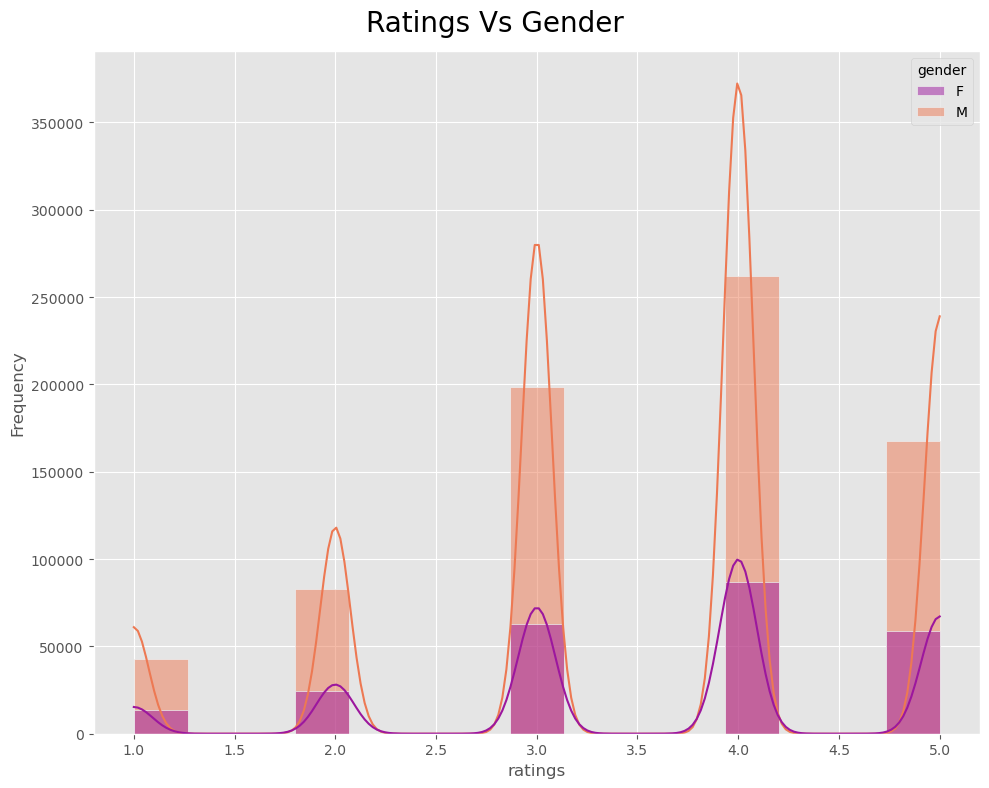

In [26]:
plt.figure(figsize=(10,8))
plt.suptitle('Ratings Vs Gender', fontsize = 20)
ax2 = sns.histplot(x = df['rating'], color= 'teal', hue= df['gender'], bins= 15, kde= True, palette= 'plasma')
ax2.set(xlabel= 'ratings', ylabel= 'Frequency')
plt.tight_layout()
plt.show()

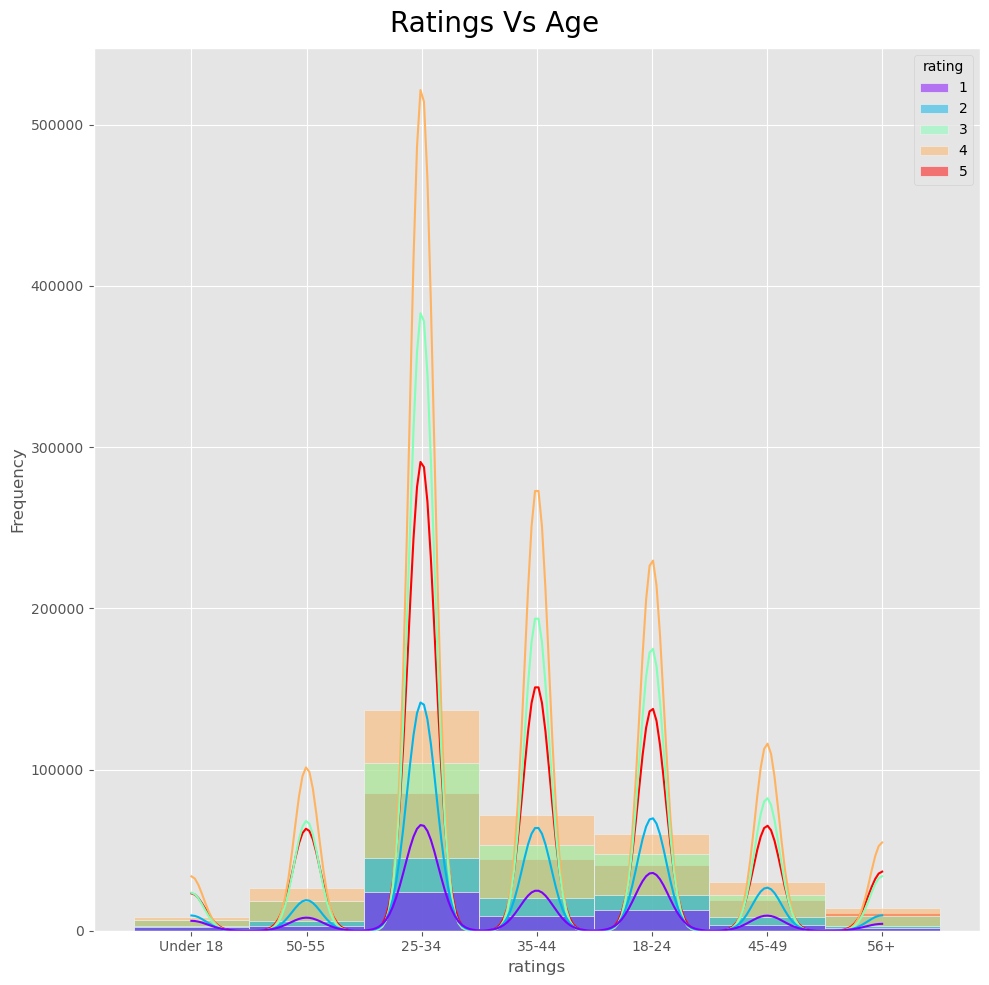

In [27]:
plt.figure(figsize=(10,10))
plt.suptitle('Ratings Vs Age', fontsize = 20)
ax2 = sns.histplot(x = df['age_desc'], color= 'teal', hue= df['rating'], bins= 15, kde= True, palette= 'rainbow')
ax2.set(xlabel= 'ratings', ylabel= 'Frequency')
plt.tight_layout()
plt.show()

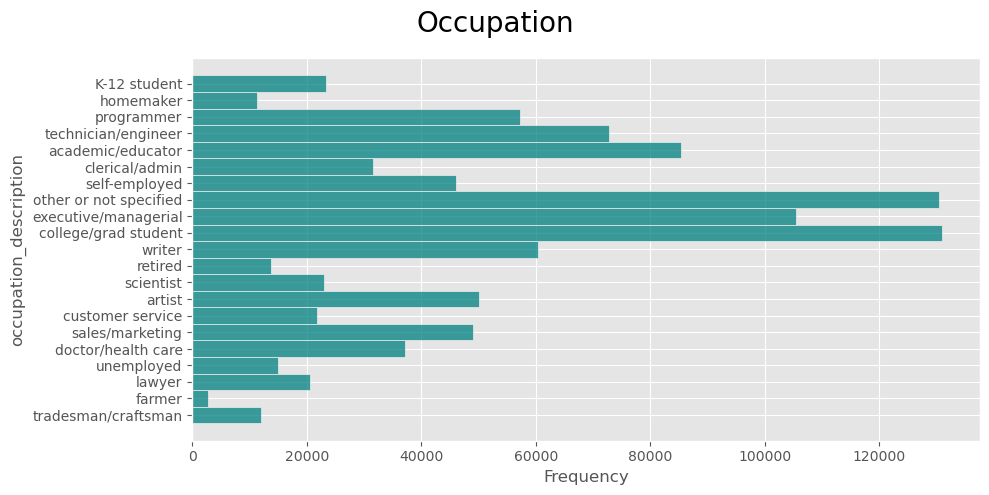

In [28]:
plt.figure(figsize=(10,5))
plt.suptitle('Occupation', fontsize = 20)
ax2 = sns.histplot(y = df['occ_desc'], color= 'teal', bins= 15, kde= False)
ax2.set(ylabel= 'occupation_description', xlabel= 'Frequency')
plt.tight_layout()
plt.show()

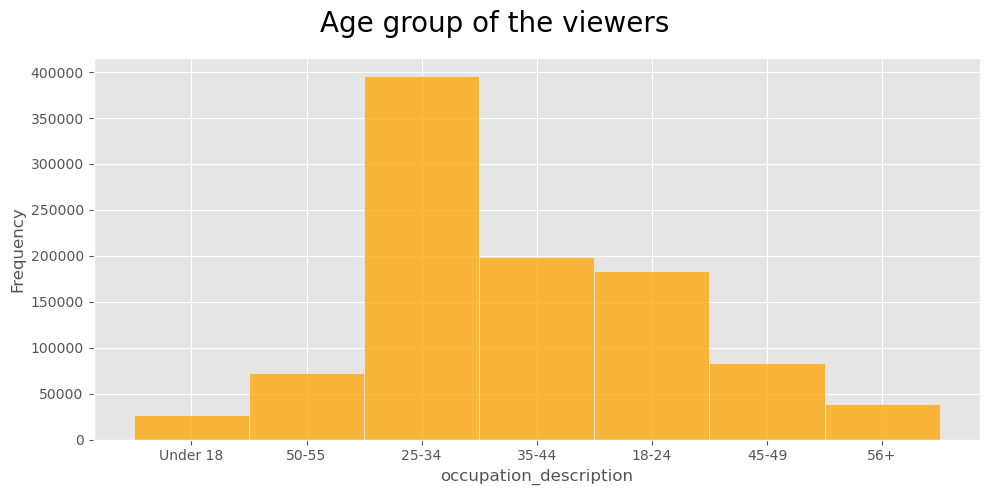

In [29]:
plt.figure(figsize=(10,5))
plt.suptitle('Age group of the viewers', fontsize = 20)
ax2 = sns.histplot(x = df['age_desc'], color= 'orange', bins= 15, kde= False)
ax2.set(xlabel= 'occupation_description', ylabel= 'Frequency')
plt.tight_layout()
plt.show()

In [30]:
genere = pd.DataFrame(keyword_occurences, columns=['Genre', 'Count'])

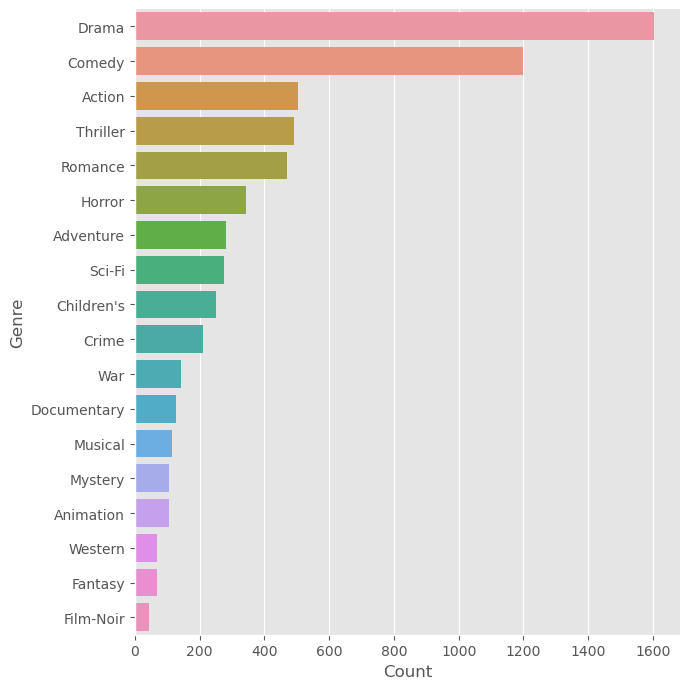

In [31]:
sns.catplot(data=genere, y='Genre', x='Count', kind='bar', height=7, aspect=1)

# modeling

In [32]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movie_id'].isin(genre_movies['movie_id'])]\
        .loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], \
                                  ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

avg_romance_rating  avg_scifi_rating
1                3.67              4.33
2                3.71              3.59
3                3.80              3.83
4                4.00              3.56
5                3.10              3.07

In [33]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =  genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) \
                      | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  302


index  avg_romance_rating  avg_scifi_rating
0      5                3.10              3.07
1     11                3.09              1.75
2     22                2.70              2.95
3     26                3.29              2.91
4     29                2.89              3.52

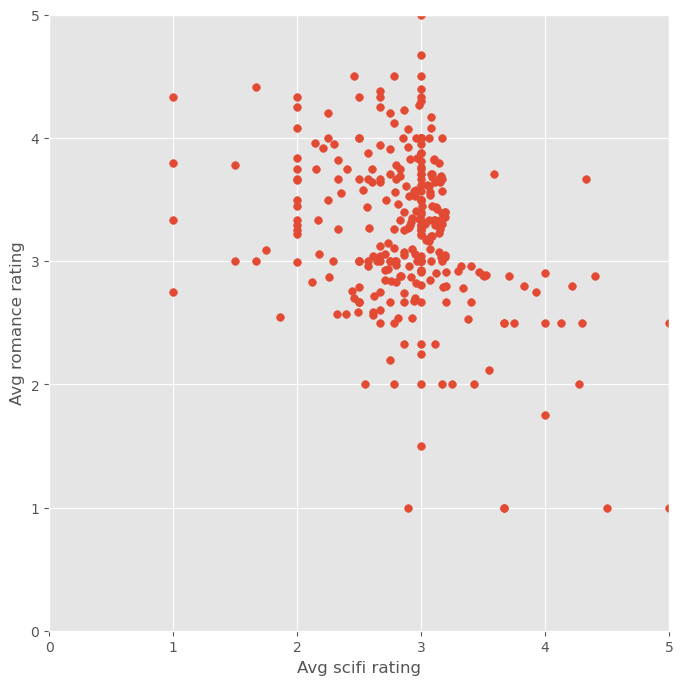

In [34]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

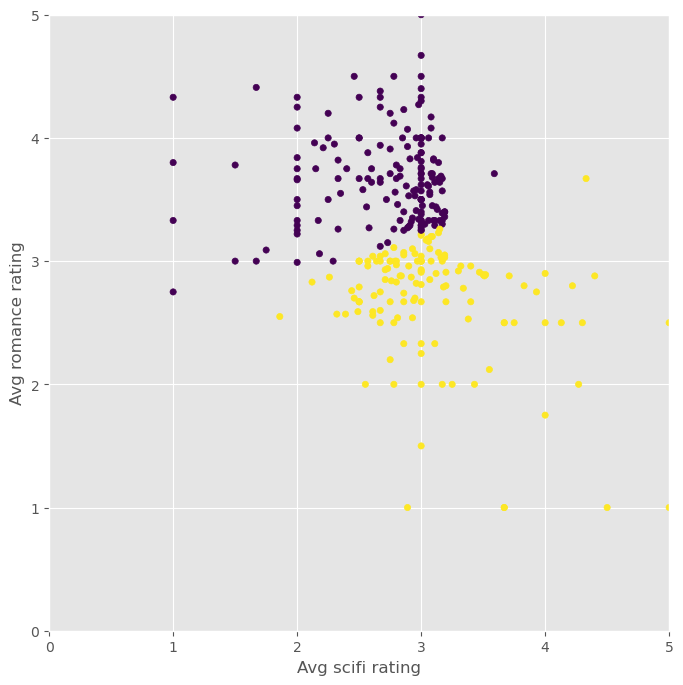

In [35]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap('viridis')
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
# Plot
draw_clusters(biased_dataset, predictions)

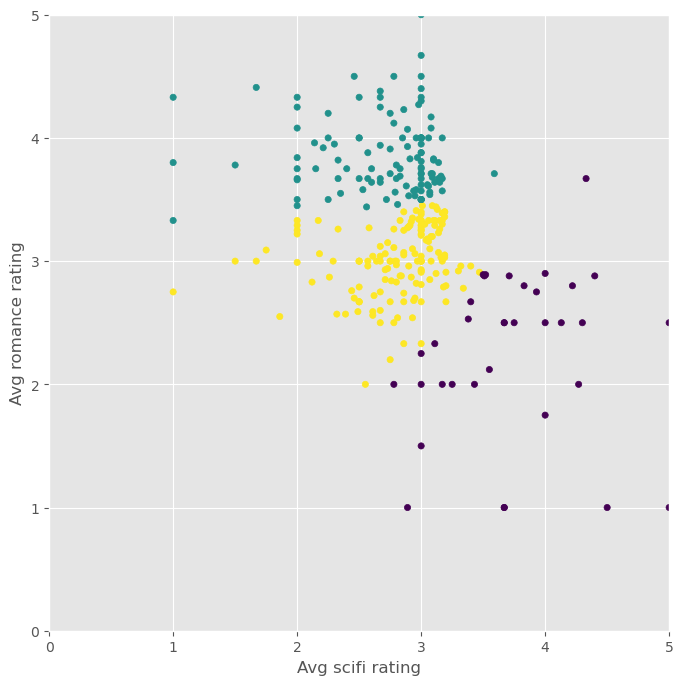

In [36]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

In [37]:
from sklearn.cluster import KMeans

In [38]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

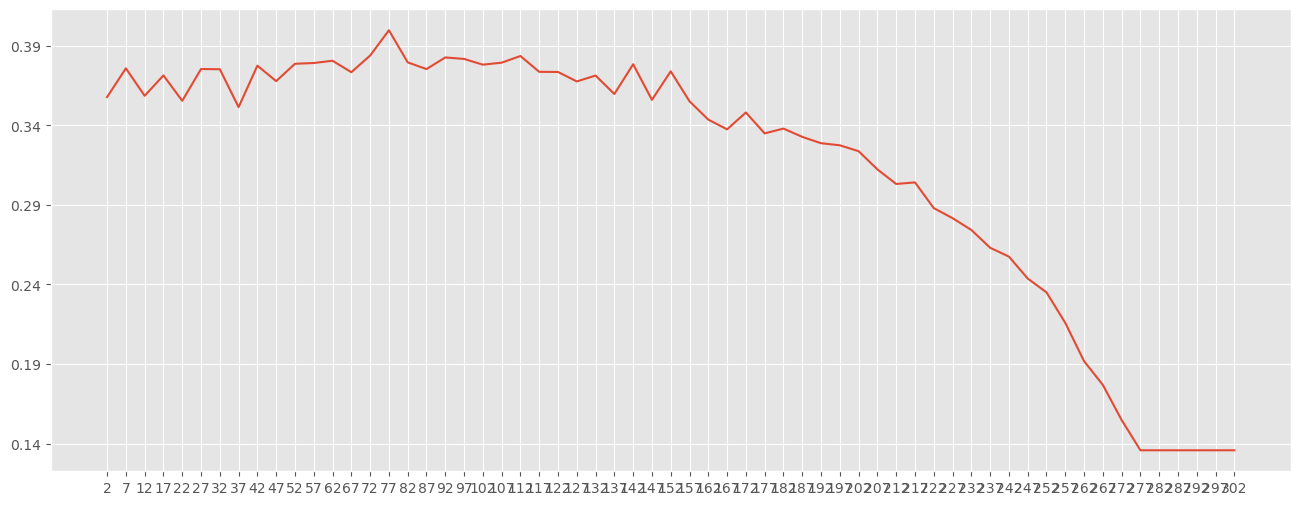

In [39]:
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

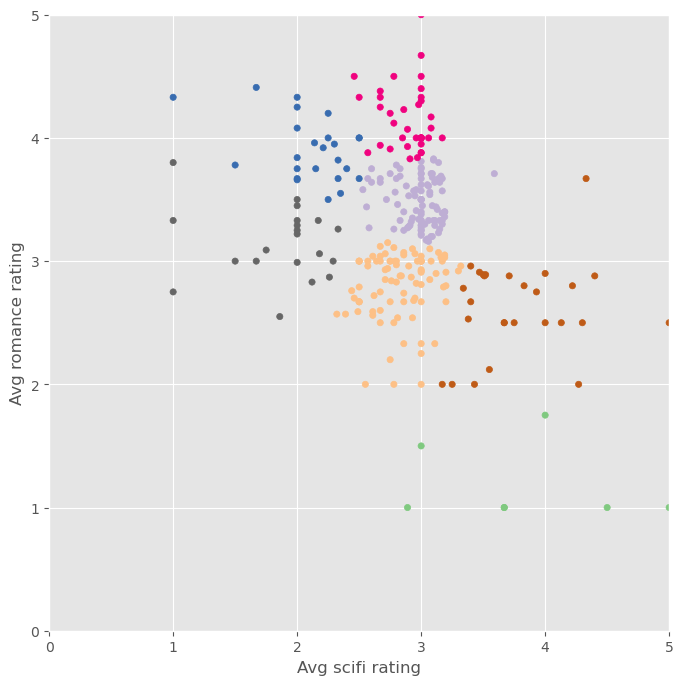

In [40]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

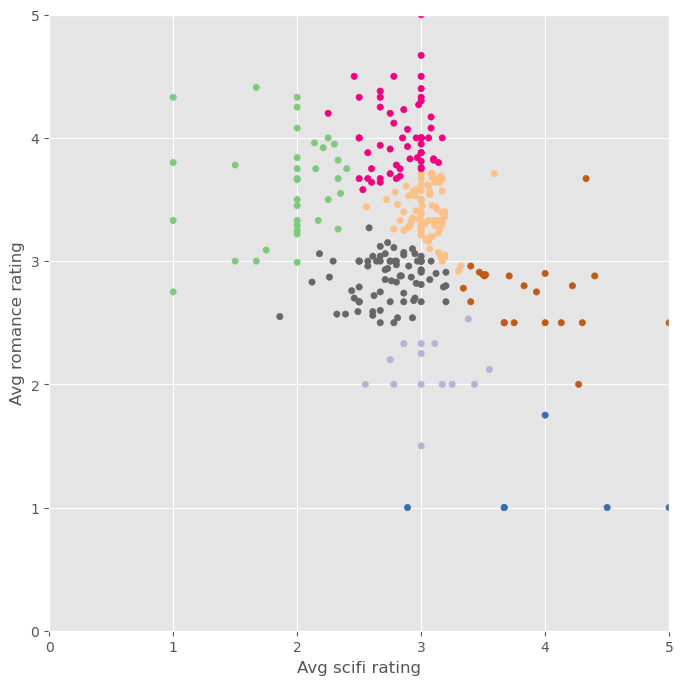

In [41]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [42]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],                                          
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  301


index  avg_romance_rating  avg_scifi_rating  avg_action_rating
0      5                3.10              3.07               2.61
1     11                3.09              1.75               3.56
2     22                2.70              2.95               2.73
3     26                3.29              2.91               3.04
4     29                2.89              3.52               3.54

In [43]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3_genres, predictions):
    clustered = pd.concat([biased_dataset_3_genres.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors=itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    fig_data = []
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 10
            else:
                size = 3
            scatter = go.Scatter3d(x=[point['avg_scifi_rating']],
                                   y=[point['avg_romance_rating']],
                                   z=[point['avg_action_rating']],
                                   mode='markers',
                                   marker=dict(color=color, size=size)
                                  )
            fig_data.append(scatter)
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=fig_data, layout=layout)
    fig.update_layout(scene=dict(xaxis_title='Avg scifi rating', yaxis_title='Avg romance rating', zaxis_title='Avg Action rating'))
    pyo.iplot(fig)
    
draw_clusters_3d(biased_dataset_3_genres, predictions_5)


# Content based Recommendation

### Cosine Similariry

In [44]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [46]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [47]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [48]:
genre_recommendations('Matrix, The (1999)').head(20)

283                Nemesis 2: Nebula (1995)
585       Terminator 2: Judgment Day (1991)
683                             Solo (1996)
738                     Arrival, The (1996)
1024              Lawnmower Man, The (1992)
1220                 Terminator, The (1984)
1533                        Face/Off (1997)
1763                   Lost in Space (1998)
2502                     Matrix, The (1999)
2531                        eXistenZ (1999)
2653                   Deep Blue Sea (1999)
3458                        Predator (1987)
3628                      Predator 2 (1990)
375                          Timecop (1994)
401     Highlander III: The Sorcerer (1994)
438                   Demolition Man (1993)
500                        No Escape (1994)
728                        Barb Wire (1996)
1362        Adrenalin: Fear the Rush (1996)
1491              Fifth Element, The (1997)
Name: title, dtype: object

In [49]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [50]:
##*************************END*************************************